In [ ]:
from google.colab import drive
uploaded = drive.mount('/content/drive/') 

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, make_scorer, classification_report,confusion_matrix
from sklearn.svm import SVC
import seaborn as sns
from matplotlib import pyplot as plt

Concatenating the two training dataframes along the rows, scaling the features using MinMaxScaler, and then assigning binary labels to the dataframes (1 for sDAT and 0 for sNC). Then shuffling the data using a random state and resets the indices.

In [ ]:
rootpath = "/content/drive/MyDrive/ML_Winter2023/A_3"

train_sDAT = pd.read_csv(rootpath+"/train.fdg_pet.sDAT.csv")
train_sNC  = pd.read_csv(rootpath+"/train.fdg_pet.sNC.csv")
test_sDAT  = pd.read_csv(rootpath+"/test.fdg_pet.sDAT.csv")
test_sNC   = pd.read_csv(rootpath+"/test.fdg_pet.sNC.csv")

DF_feat = ['f1', 'f2', 'f3', 'f4','f5', 'f6','f7', 'f8', 'f9', 'f10','f11', 'f12','f13', 'f14']

train_sDAT.columns = DF_feat
train_sNC.columns =  DF_feat
test_sDAT.columns = DF_feat
test_sNC.columns = DF_feat

shape_Df = pd.DataFrame({'sNC:': [train_sNC.shape, test_sNC.shape], 'sDAT:': [train_sDAT.shape, test_sDAT.shape]})
shape_Df.index = ['Training_set: ', 'Testing_set: ']
print("Shape of Dataframe: ", shape_Df)

#training the dataset

ds_train = pd.concat([train_sDAT,train_sNC], axis = 0, ignore_index=True)
train_X =  MinMaxScaler().fit_transform(ds_train.values)
train_X = pd.DataFrame(train_X)
train_X.columns = DF_feat

label1 = pd.DataFrame([1 for i in range(len(train_sDAT))])
label0 = pd.DataFrame([0 for i in range(len(train_sNC))])
y_train = pd.concat([label1, label0], axis = 0, ignore_index=True)
y_train.columns = ["Diagnosis"]

train_X2 = train_X.sample(frac=1, random_state=43)
train_y2 = y_train.loc[train_X2.index]
train_X = train_X2.reset_index(drop=True)
train_y = train_y2.reset_index(drop=True) 



Shape of Dataframe:                       sNC:      sDAT:
Training_set:   (236, 14)  (236, 14)
Testing_set:    (414, 14)  (121, 14)


The test dataset is prepared by concatenating the test_sDAT and test_sNC dataframes and scaling the features using MinMaxScaler(). The labels are also assigned by creating two separate dataframes label1 and label0 for positive and negative samples respectively and concatenating them along the rows. The test dataset is then shuffled and assigned new indices using the sample() method, and the labels are also shuffled correspondingly. Finally, the shapes of the training and testing datasets are printed.

In [ ]:
# Test dataset
data_test = pd.concat([test_sDAT,test_sNC], axis = 0, ignore_index=True)
test_X = MinMaxScaler().fit_transform(data_test.values)
test_X = pd.DataFrame(test_X)
test_X.columns = DF_feat

label1 = pd.DataFrame([1 for i in range(len(test_sDAT))])
label0 = pd.DataFrame([0 for i in range(len(test_sNC))])
test_y = pd.concat([label1, label0], axis = 0, ignore_index=True)
test_y.columns = ["Diagnosis"]

test_X2 = test_X.sample(frac=1, random_state=44)
test_y2 = test_y.loc[test_X2.index]
test_X = test_X2.reset_index(drop=True)
test_y = test_y2.reset_index(drop=True) 

shape_Df = pd.DataFrame({'X': [train_X.shape,test_X.shape],'y': [train_y.shape, test_y.shape]})
shape_Df.index = ['Training_values','Testing_values']
print('Shape of the Dataset: \n', shape_Df)

Shape of the Dataset: 
                          X         y
Training_values  (472, 14)  (472, 1)
Testing_values   (535, 14)  (535, 1)


Two functions for hyperparameter tuning and evaluation of a Support Vector Machine (SVM) classifier are defined.

The evaluate_model function takes the true labels and predicted labels as inputs and calculates and prints performance metrics such as accuracy, sensitivity, specificity, precision, and balanced accuracy. It also prints the classification report and confusion matrix and shows a heatmap of the confusion matrix.

The tune_svm function performs grid search to tune the hyperparameters of the SVM classifier using the provided parameter grid. The function takes training and test data and labels as inputs, and fits the grid search to the training data. The best model is printed and evaluated on the test set using the evaluate_model function. Additionally, the function plots the mean test score for each value of the regularization parameter C using a heatmap. The optimal value of C and corresponding R2 score are also printed on the plot. Finally, the function returns the best model.






In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

global param_c

def evaluate_model(y_true, y_pred):
    """Compute performance metrics and print classification report and confusion matrix."""
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    # Calculate metrics
    p  = tp + fn
    n  = fp + tn
    pp = tp + fp
    pn = fn + tn

    acc = (tp + tn)/(p + n)
    sen = tp/p
    spe = tn/n
    pre = tp/pp
    bal = (sen + spe)/2 

    # Print classification report and confusion matrix
    print('Classification report: \n', classification_report(y_true, y_pred),'\n')
    plt.figure(figsize=(6,4))
    sns.heatmap(confusion_matrix(y_true, y_pred),annot=True)
    plt.savefig("Q3_conf.eps", format='eps')
    plt.show()

    # Print metrics
    metric_report = pd.DataFrame({'Values': [acc, sen, spe, pre, bal]})
    metric_report.index = ['Accuracy:', 'Sensitivity:', 'Specificity:', 'Precision:', 'Balanced Accuracy:']
    print('Metrics report: \n', metric_report)

    return acc, sen, spe, pre, bal
def tune_svm(param_grid, X_train, y_train, X_test, y_test):
    """Perform grid search to tune an SVM classifier and evaluate the best model on the test set."""
    if train_X.shape[0] != train_y.shape[0]:
        raise ValueError("'train_X' and 'train_y' must have the same number of samples")
   
    if test_X.shape[0] != test_y.shape[0]:
        raise ValueError("'test_X' and 'test_y' must have the same number of samples")
   
    # Instantiate grid search with SVM classifier and parameter grid
    grid_search = GridSearchCV(SVC(), param_grid, refit=True)

    # Fit grid search to training data
    grid_search.fit(X_train, y_train.values.ravel())

    # Print best model after hyperparameter tuning
    best_model = grid_search.best_estimator_
    print('Best model after hyperparameter tuning: \n', best_model, '\n')

    # Evaluate best model on test set
    y_test_pred = best_model.predict(X_test)
    evaluate_model(y_test, y_test_pred)

    #tuning and performance model
    mean_scores = grid_search.cv_results_['mean_test_score']
    std_scores = grid_search.cv_results_['std_test_score']
    mean_scores_grid = mean_scores.reshape(len(param_grid['C']), -1).T
    std_scores_grid = std_scores.reshape(len(param_grid['C']), -1).T
    #fig, ax = plt.subplots()
    mean_c = mean_scores.reshape(len(param_c),int(len(mean_scores)/len(param_c))).transpose()
    std_scores  = std_scores.reshape(len(param_c),int(len(mean_scores)/len(param_c))).transpose()
    p = list(grid_search.param_grid.values())[-1]
    f, c = np.where(mean_c == np.max(mean_c))

    plt.figure(figsize=(8,5))
    for ind in range(0,int(len(mean_scores)/len(param_c))):
     plt.plot(param_c, mean_c[ind], marker='X', label= str(p[ind]))
    plt.grid()
    plt.xscale('log')
    plt.legend(fontsize=15)
    plt.xlabel("Regularization Parameter, C", fontsize=15, color="blue")
    plt.ylabel('Mean Test Score', fontsize=15)
    plt.text(param_c[f][0], mean_c[f,c][0],  "C = {:.6f}\nR2 = {:.6f}".format(param_c[c][0],mean_c[f,c][0]), fontsize=15)
    plt.savefig("Q3_svc1.eps", format='eps')
    plt.title('Model performance as a function of C', loc='right')
    plt.show()

    return best_model    

# **Question 1**
Train a linear SVM classification model to discriminate between the sNC and sDAT individuals based on the brain glucose metabolism features. Use the “training” dataset and a cross-validation (CV) based grid-search approach to tune the regularization parameter “C” of the linear SVM model. Using the “best” “C” setting, re-train on the entire “training” dataset to obtain the final linear SVM classification model. Estimate the “Err” of this final model on the “test” dataset. Plot and discuss the performance of the models explored during the “C” hyperparameter tuning phase as function of “C”.

**Discussion: **

We are tuning a Support Vector Machine (SVM) classifier using grid search with cross-validation to find the best hyperparameters. The hyperparameter being tuned is the regularization parameter C, which controls the trade-off between maximizing the margin and minimizing the classification error. The range of C values to be tested is defined by np.logspace(-5, 5, 10), which generates a sequence of 10 numbers logarithmically spaced between 1e-5 and 1e5. The SVM is being trained with a linear kernel, specified by the kernel parameter in param_grid. The tune_svm function takes the hyperparameter grid, training and testing data as inputs, and returns the best model found by the grid search, along with its performance metrics evaluated on the test set.

Best model after hyperparameter tuning: 
 SVC(C=3.593813663804626, kernel='linear') 

Classification report: 
               precision    recall  f1-score   support

           0       0.96      0.86      0.91       414
           1       0.65      0.89      0.76       121

    accuracy                           0.87       535
   macro avg       0.81      0.88      0.83       535
weighted avg       0.89      0.87      0.88       535
 



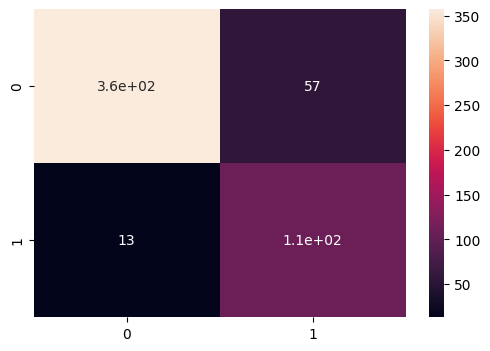

Metrics report: 
                       Values
Accuracy:           0.869159
Sensitivity:        0.892562
Specificity:        0.862319
Precision:          0.654545
Balanced Accuracy:  0.877440


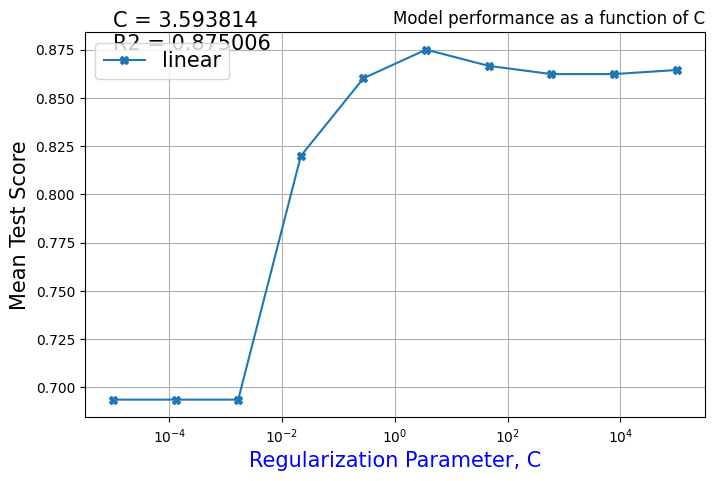

SVC(C=3.593813663804626, kernel='linear')

In [ ]:
#question 1
import numpy as np
param_c    = np.logspace(-5, 5, 10) 
param_grid = {'C': param_c, 'kernel':['linear']}
tune_svm(param_grid, train_X, train_y, test_X, test_y)

# **Question 2**
Now train a non-linear SVM classifier with a polynomial kernel for the sNC vs sDAT classification task. Use the “training” dataset and a CV based grid-search approach to tune both the regularization parameter “C” as well as the degree “d” parameter of the polynomial kernel. Using the “best” “(C, d)” setting, re-train on the entire “training” dataset to obtain the final polynomial kernel SVM model. Estimate the “Err” of this final model on the “test” dataset. Compare the performance of the polynomial kernel SVM model with that of the above obtained final linear SVM model.

A polynomial SVM kernel is being tuned by performing a grid search over a range of values for the regularization parameter C and the degree of the polynomial kernel. The function tune_svm() is called with the parameter grid specified by param_grid, which includes the values of param_c and param_d as the range of values to be searched for C and degree respectively. The SVM kernel being used is 'poly' which is the polynomial kernel.

The tune_svm() function performs a grid search using GridSearchCV from Scikit-learn library. It fits the SVM classifier to the training data and then evaluates the best model on the test data. Finally, it plots a graph of the mean test scores for different values of C and degree

Best model after hyperparameter tuning: 
 SVC(C=10.0, degree=2, kernel='poly') 

Classification report: 
               precision    recall  f1-score   support

           0       0.98      0.86      0.91       414
           1       0.66      0.93      0.77       121

    accuracy                           0.87       535
   macro avg       0.82      0.90      0.84       535
weighted avg       0.91      0.87      0.88       535
 



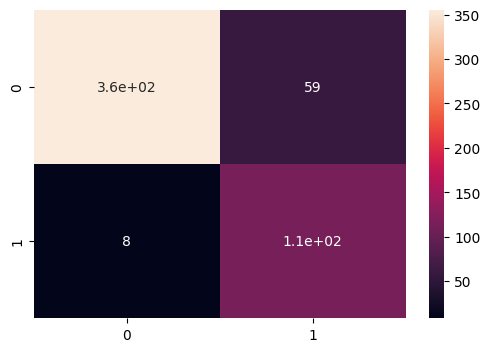

Metrics report: 
                       Values
Accuracy:           0.874766
Sensitivity:        0.933884
Specificity:        0.857488
Precision:          0.656977
Balanced Accuracy:  0.895686


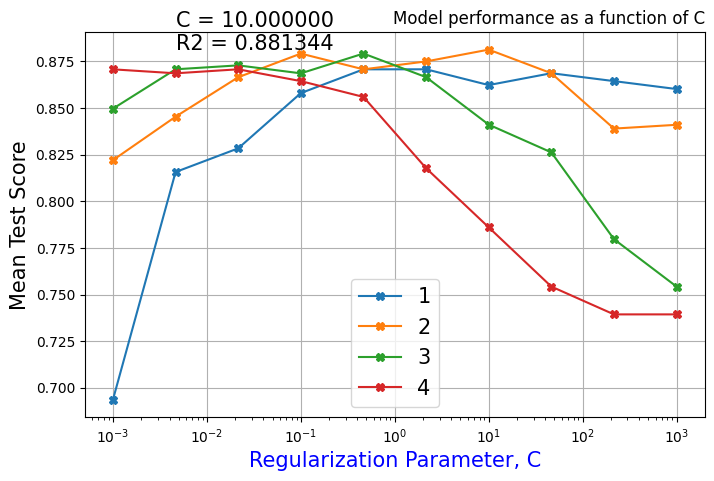

SVC(C=10.0, degree=2, kernel='poly')

In [ ]:
#Question 2
param_d    = [1,2,3,4]
param_grid = {'C': param_c, 'kernel':['poly'], 'degree': param_d}
tune_svm(param_grid, train_X, train_y, test_X, test_y)

# **Question 3**
Repeat the above experiment by replacing the polynomial kernel with a radial basis function (RBF) kernel. Note that here the RBF kernel parameter “γ” needs to be tuned instead of the “d” parameter of the polynomial kernel. Compare the performance of the final RBF kernel SVM classification model with that of both the final polynomial kernel SVM and the linear SVM models.

This code is performing hyperparameter tuning for an SVM classifier using radial basis function (RBF) kernel. The SVM classifier is tuned using a grid search with different combinations of hyperparameters. The hyperparameters being tuned here are the regularization parameter C and the kernel coefficient gamma. The range of values for C and gamma are defined using the param_c and param_y arrays, respectively. The param_grid dictionary defines the different hyperparameter combinations to be tested by the grid search. The tune_svm function fits the SVM classifier with each combination of hyperparameters and selects the best model based on the performance on the training data. Finally, the performance of the best model is evaluated on the test data using the evaluate_model function, which computes various performance metrics and prints the classification report and confusion matrix. Additionally, the function also plots the mean test score of the hyperparameter combinations as a function of C, and highlights the best hyperparameters with a text box in the plot.

Best model after hyperparameter tuning: 
 SVC(C=46.41588833612782, gamma=1) 

Classification report: 
               precision    recall  f1-score   support

           0       0.98      0.83      0.90       414
           1       0.62      0.95      0.75       121

    accuracy                           0.86       535
   macro avg       0.80      0.89      0.83       535
weighted avg       0.90      0.86      0.87       535
 



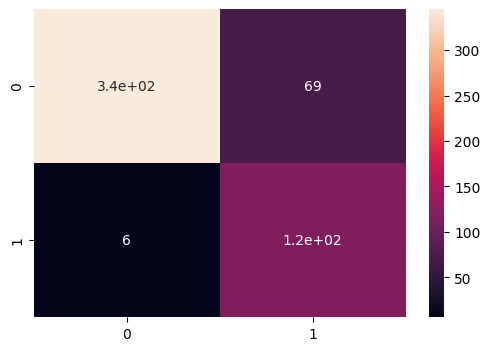

Metrics report: 
                       Values
Accuracy:           0.859813
Sensitivity:        0.950413
Specificity:        0.833333
Precision:          0.625000
Balanced Accuracy:  0.891873


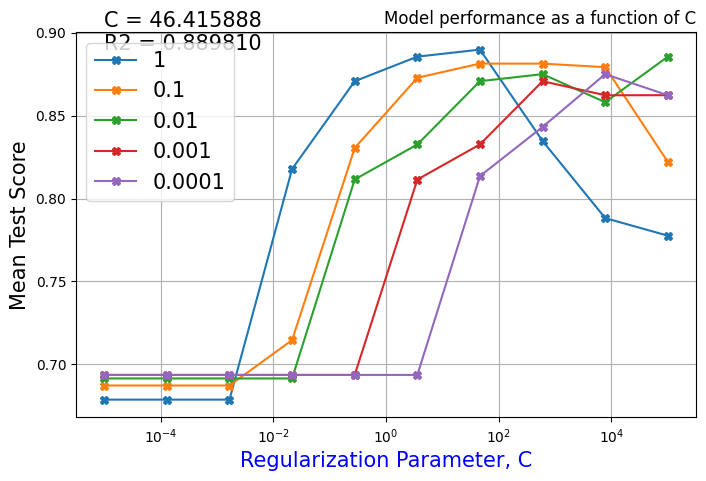

SVC(C=46.41588833612782, gamma=1)

In [ ]:
# Question 3
param_y    = [1, 0.1, 0.01, 0.001, 0.0001]
param_grid = {'C': param_c, 'kernel':['rbf'], 'gamma': param_y}
tune_svm(param_grid, train_X, train_y, test_X, test_y)